In [1]:
# PIP Installs
!/opt/conda/bin/python3.7 -m pip install -q --upgrade pip      # Upgrade PIP
!pip install -q pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg # Install/Upgrade PyDicom Dependencies

# Built In Imports
from datetime import datetime
from glob import glob
import warnings
import IPython
import urllib
import zipfile
import pickle
import shutil
import string
import math
import tqdm
import time
import os
import gc
import re

# Visualization Imports
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from PIL import Image
import matplotlib
import plotly
import PIL
import cv2

# Other Imports
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tqdm.notebook import tqdm
import pydicom
import pandas as pd
import numpy as np


FIG_FONT = dict(family="Helvetica, Arial", size=14, color="#7f7f7f")
LABEL_COLORS = [px.colors.label_rgb(px.colors.convert_to_RGB_255(x)) for x in sns.color_palette("Spectral", 15)]
LABEL_COLORS_WOUT_NO_FINDING = LABEL_COLORS[:8]+LABEL_COLORS[9:]

print("\n... IMPORTS COMPLETE ...\n")


... IMPORTS COMPLETE ...





The dataset comprises 18,000 postero-anterior (PA) CXR scans in DICOM format, which were de-identified to protect patient privacy.

All images were labeled by a panel of experienced radiologists for the presence of 14 critical radiographic findings as listed below:
>   0 - Aortic enlargement

>   1 - Atelectasis

>   2 - Calcification

>   3 - Cardiomegaly
    
>   4 - Consolidation
    
>   5 - ILD
    
>   6 - Infiltration
    
>   7 - Lung Opacity
    
>   8 - Nodule/Mass
    
>   9 - Other lesion
    
>   10 - Pleural effusion
    
>   11 - Pleural thickening
    
>    12 - Pneumothorax
    
>    13 - Pulmonary fibrosis
    
>    14 - "No finding" observation was intended to capture the absence of all findings above

Note that a key part of this competition is working with ground truth from multiple radiologists. That means that the same image will have multiple ground-truth labels as annotated by different radiologists.

*TRAIN COLUMNS*

>    image_id - unique image identifier
 
>   class_name - the name of the class of detected object (or "No finding")
    
>   class_id - the ID of the class of detected object

>   rad_id - the ID of the radiologist that made the observation

>   x_min - minimum X coordinate of the object's bounding box

>   y_min - minimum Y coordinate of the object's bounding box

>   x_max - maximum X coordinate of the object's bounding box

>   y_max - maximum Y coordinate of the object's bounding box


# Path Setup

In [2]:
DATA_DIR = "/kaggle/input/vinbigdata-chest-xray-abnormalities-detection"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

TRAIN_DICOM_PATHS = [os.path.join(TRAIN_DIR, f_name) for f_name in os.listdir(TRAIN_DIR)]
TEST_DICOM_PATHS = [os.path.join(TEST_DIR, f_name) for f_name in os.listdir(TEST_DIR)]
print(f"\n... The number of training files is {len(TRAIN_DICOM_PATHS)} ...")
print(f"... The number of testing files is {len(TEST_DICOM_PATHS)} ...")

TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
SS_CSV = os.path.join(DATA_DIR, "sample_submission.csv")

train_df = pd.read_csv(TRAIN_CSV)
ss_df = pd.read_csv(SS_CSV)

print("\n\nTRAIN DATAFRAME\n\n")
display(train_df.head(3))

print("\n\nSAMPLE SUBMISSION DATAFRAME\n\n")
display(ss_df.head(3))


... The number of training files is 15000 ...
... The number of testing files is 3000 ...


TRAIN DATAFRAME




image_id    class_name  class_id rad_id  x_min  \
0  50a418190bc3fb1ef1633bf9678929b3    No finding        14    R11    NaN   
1  21a10246a5ec7af151081d0cd6d65dc9    No finding        14     R7    NaN   
2  9a5094b2563a1ef3ff50dc5c7ff71345  Cardiomegaly         3    R10  691.0   

    y_min   x_max   y_max  
0     NaN     NaN     NaN  
1     NaN     NaN     NaN  
2  1375.0  1653.0  1831.0



SAMPLE SUBMISSION DATAFRAME




image_id PredictionString
0  002a34c58c5b758217ed1f584ccbcfe9     14 1 0 0 1 1
1  004f33259ee4aef671c2b95d54e4be68     14 1 0 0 1 1
2  008bdde2af2462e86fd373a445d0f4cd     14 1 0 0 1 1

# Functions

In [3]:
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    """
    Convert dicom file to numpy array
    
    Args:
        path (str): Path to the dicom file to be converted
        voi_lut (bool): Whether or not VOI LUT is available
        fix_monochrome (bool): Whether or not to aply monochrome fix
    
    Returns:
        Numpy array of the respective dicom file
    """
    
    dicom = pydicom.read_file(path)
    
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    
    return data

def plot_image(img, title='', figsize=(8,8), cmap=None):
    """Function to plot an image to save a bit of time"""
    plt.figure(figsize=figsize)
    
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)
    plt.title(title, font_weight='bold')
    plt.axis(False)
    plt.show()
    
def get_image_id(path):
    """Function to return the image-id from a path"""
    return path.rsplit("/", 1)[1].rsplit(".", 1)[0]

def create_fractional_bbox_coordinates(row):
    """Function to return bbox coordinates as fractions from DF row"""
    
    frac_x_min = row['x_min']/row['img_width']
    frac_x_max = row['x_max']/row['img_width']
    frac_y_min = row['y_min']/row['img_height']
    frac_y_max = row['y_max']/row['img_height']
    
    return frac_x_min, frac_x_max, frac_y_min, frac_y_max

def draw_bboxes(img, tl, br, rgb, label="", label_location="tl", opacity=0.1,line_thickness=0):
    """
    TBD
    
    Args:
        TBD
        
    Return:
        TBD
    """
    rect = np.uint8(np.ones((br[1]-tl[1], br[0] - tl[0], 3)) *rgb)
    sub_combo = cv2.addWeighted(img[tl[1]:br[1], tl[0]:br[0], :],1-opacity, rect, opacity, 1.0)
    img[tl[1]:br[1], tl[0]:br[0], :] = sub_combo
    
    if line_thickness > 0:
        img = cv2.rectangle(img, tuple(tl), tuple(br), rgb, line_thickness)
        
    if label:
        FONT = cv2.FONT_HERSHEY_SIMPLEX
        FONT_SCALE = 1.666
        FONT_THICKNESS = 3
        FONT_LINE_TYPE = cv2.LINE_AA
        
        if type(label)==str:
            LABEL = label.upper().replace(" ", "_")
        else:
            LABEL = f"CLASS_{label:02}"
        
        text_width, text_height = cv2.getTextSize(LABEL, FONT, FONT_SCALE, FONT_THICKNESS)[0]
        
        label_origin = {"tl": tl, "br": br, "tr":(br[0], tl[1]), "bl":(tl[0],br[1])}[label_location]
        
        label_offset = {
            "tl":np.array([0 , -10]), "br":np.array([-text_width, text_height+10]),
            "tr":np.array([-text_width, -10]), "bl":np.array([0, text_height+10])
        }[label_location]
        img = cv2.putText(img, LABEL, tuple(label_origin+label_offset),
                          FONT, FONT_SCALE, rgb, FONT_THICKNESS, FONT_LINE_TYPE)
    return img

In [4]:
int_2_str = {i:train_df[train_df["class_id"]==i].iloc[0]["class_name"] for i in range(15)}
str_2_int = {v:k for k,v in int_2_str.items()}
int_2_clr = {str_2_int[k]:LABEL_COLORS[i] for i,k in enumerate(sorted(str_2_int.keys()))}

print("\n... Dictionary Mapping Class Integer to Class String Representation [int_2_str]...\n")
display(int_2_str)

print("\n... Dictionary Mapping Class String to Class Integer Representation [str_2_int]...\n")
display(str_2_int)

print("\n... Dictionary Mapping Class Integer to Color Representation [str_2_clr]...\n")
display(int_2_clr)

print("\n... Head of Train Dataframe After Dropping The Class Name Column...\n")
train_df.drop(columns=["class_name"], inplace=True)
display(train_df.head(5))


... Dictionary Mapping Class Integer to Class String Representation [int_2_str]...



{0: 'Aortic enlargement',
 1: 'Atelectasis',
 2: 'Calcification',
 3: 'Cardiomegaly',
 4: 'Consolidation',
 5: 'ILD',
 6: 'Infiltration',
 7: 'Lung Opacity',
 8: 'Nodule/Mass',
 9: 'Other lesion',
 10: 'Pleural effusion',
 11: 'Pleural thickening',
 12: 'Pneumothorax',
 13: 'Pulmonary fibrosis',
 14: 'No finding'}


... Dictionary Mapping Class String to Class Integer Representation [str_2_int]...



{'Aortic enlargement': 0,
 'Atelectasis': 1,
 'Calcification': 2,
 'Cardiomegaly': 3,
 'Consolidation': 4,
 'ILD': 5,
 'Infiltration': 6,
 'Lung Opacity': 7,
 'Nodule/Mass': 8,
 'Other lesion': 9,
 'Pleural effusion': 10,
 'Pleural thickening': 11,
 'Pneumothorax': 12,
 'Pulmonary fibrosis': 13,
 'No finding': 14}


... Dictionary Mapping Class Integer to Color Representation [str_2_clr]...



{0: 'rgb(193, 39, 74)',
 1: 'rgb(221, 74, 76)',
 2: 'rgb(240, 103, 68)',
 3: 'rgb(249, 142, 82)',
 4: 'rgb(253, 181, 103)',
 5: 'rgb(254, 212, 129)',
 6: 'rgb(254, 236, 159)',
 7: 'rgb(255, 255, 190)',
 14: 'rgb(239, 249, 166)',
 8: 'rgb(214, 238, 155)',
 9: 'rgb(177, 223, 163)',
 10: 'rgb(134, 207, 165)',
 11: 'rgb(94, 185, 169)',
 12: 'rgb(61, 149, 184)',
 13: 'rgb(68, 113, 178)'}


... Head of Train Dataframe After Dropping The Class Name Column...



image_id  class_id rad_id   x_min   y_min   x_max  \
0  50a418190bc3fb1ef1633bf9678929b3        14    R11     NaN     NaN     NaN   
1  21a10246a5ec7af151081d0cd6d65dc9        14     R7     NaN     NaN     NaN   
2  9a5094b2563a1ef3ff50dc5c7ff71345         3    R10   691.0  1375.0  1653.0   
3  051132a778e61a86eb147c7c6f564dfe         0    R10  1264.0   743.0  1611.0   
4  063319de25ce7edb9b1c6b8881290140        14    R10     NaN     NaN     NaN   

    y_max  
0     NaN  
1     NaN  
2  1831.0  
3  1019.0  
4     NaN

In [5]:
bbox_df = train_df[train_df.class_id !=14].reset_index(drop=True)

BBOX_PATHS = [
    os.path.join(TRAIN_DIR, name+".dicom") \
    for name in bbox_df.image_id.unique()
]

sizes_of_images_w_bboxes = {}

for path in tqdm(BBOX_PATHS, total=len(BBOX_PATHS)):
    dicom = pydicom.read_file(path)
    sizes_of_images_w_bboxes[path[:-6].rsplit("/", 1)[1]] = \
    (dicom.Rows, dicom.Columns)
    

bbox_df['img_height'] = bbox_df['image_id'].map(lambda x: sizes_of_images_w_bboxes[x][0])
bbox_df['img_width'] = bbox_df['image_id'].map(lambda x: sizes_of_images_w_bboxes[x][1])

bbox_df["frac_x_min"], bbox_df["frac_x_max"], bbox_df["frac_y_min"], bbox_df["frac_y_max"] = \
    zip(*bbox_df.apply(create_fractional_bbox_coordinates, axis=1))

# # Record some important values for later
ave_src_img_height = np.mean([size[0] for size in sizes_of_images_w_bboxes.values()], dtype=np.int32)
ave_src_img_width  = np.mean([size[1] for size in sizes_of_images_w_bboxes.values()], dtype=np.int32)

bbox_df.head()

  0%|          | 0/4394 [00:00<?, ?it/s]

image_id  class_id rad_id   x_min   y_min   x_max  \
0  9a5094b2563a1ef3ff50dc5c7ff71345         3    R10   691.0  1375.0  1653.0   
1  051132a778e61a86eb147c7c6f564dfe         0    R10  1264.0   743.0  1611.0   
2  1c32170b4af4ce1a3030eb8167753b06        11     R9   627.0   357.0   947.0   
3  0c7a38f293d5f5e4846aa4ca6db4daf1         5    R17  1347.0   245.0  2188.0   
4  47ed17dcb2cbeec15182ed335a8b5a9e         8     R9   557.0  2352.0   675.0   

    y_max  img_height  img_width  frac_x_min  frac_x_max  frac_y_min  \
0  1831.0        2336       2080    0.332212    0.794712    0.588613   
1  1019.0        2880       2304    0.548611    0.699219    0.257986   
2   433.0        3072       2540    0.246850    0.372835    0.116211   
3  2169.0        2555       2285    0.589497    0.957549    0.095890   
4  2484.0        3353       2568    0.216900    0.262850    0.701461   

   frac_y_max  
0    0.783818  
1    0.353819  
2    0.140951  
3    0.848924  
4    0.740829

  0%|          | 0/36096 [00:00<?, ?it/s]

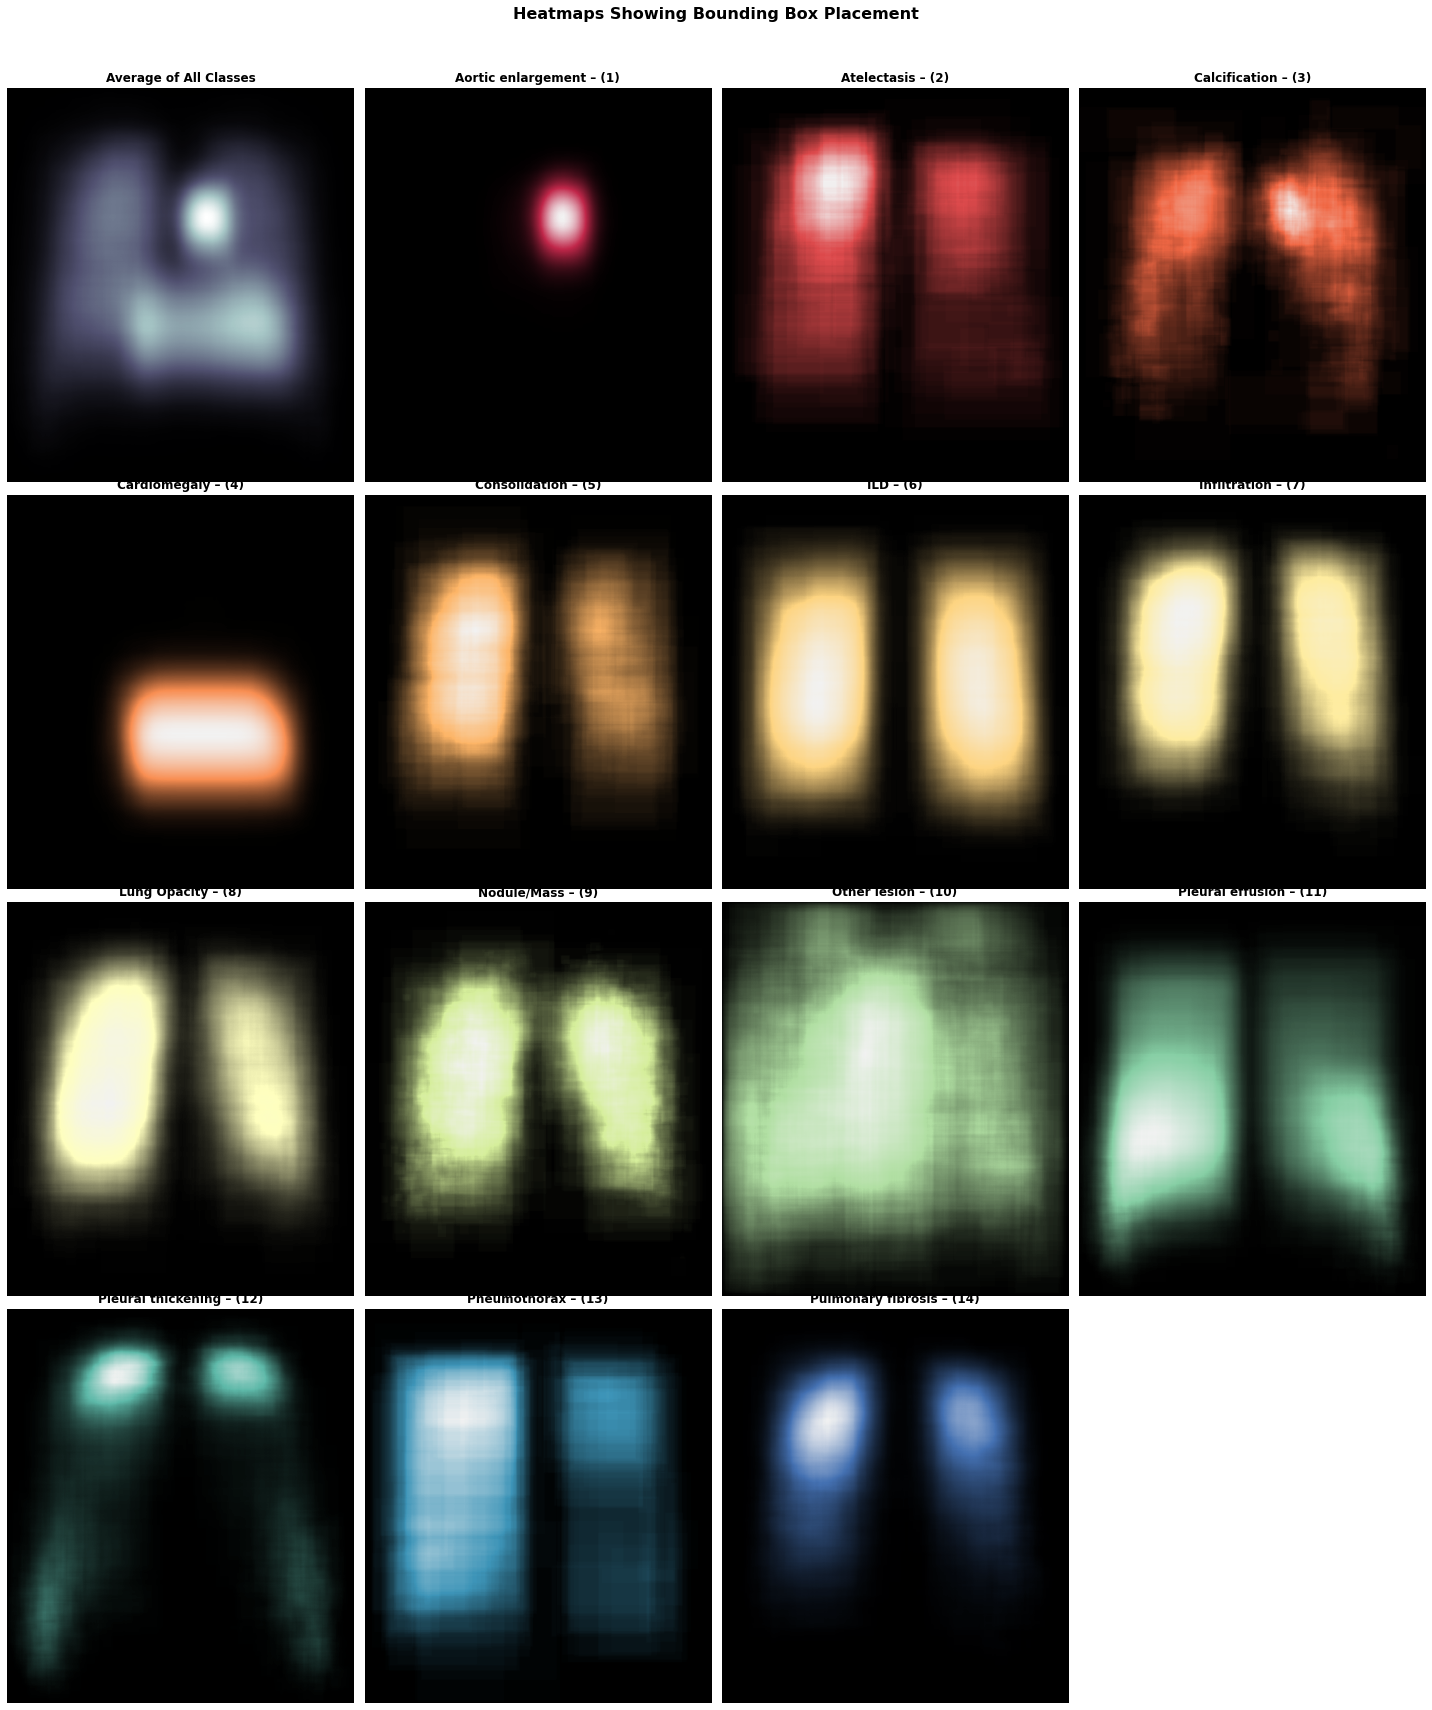

In [6]:
# DEFAULT
HEATMAP_SIZE = (ave_src_img_height, ave_src_img_width, 14)

# Initialize
heatmap = np.zeros((HEATMAP_SIZE), dtype=np.int16)
bbox_np = bbox_df[["class_id", "frac_x_min", "frac_x_max", "frac_y_min", "frac_y_max"]].to_numpy()
bbox_np[:, 1:3] *= ave_src_img_width
bbox_np[:, 3:5] *= ave_src_img_height
bbox_np = np.floor(bbox_np).astype(np.int16)

# Color map stuff
custom_cmaps = [
    matplotlib.colors.LinearSegmentedColormap.from_list(
        colors=[(0.,0.,0.), c, (0.95,0.95,0.95)], 
        name=f"custom_{i}") for i,c in enumerate(sns.color_palette("Spectral", 15))
]
custom_cmaps.pop(8) # Remove No-Finding

for row in tqdm(bbox_np, total=bbox_np.shape[0]):
    heatmap[row[3]:row[4]+1, row[1]:row[2]+1, row[0]] += 1
    
fig = plt.figure(figsize=(20,25))
plt.suptitle("Heatmaps Showing Bounding Box Placement\n ", fontweight="bold", fontsize=16)
for i in range(15):
    plt.subplot(4, 4, i+1)
    if i==0:
        plt.imshow(heatmap.mean(axis=-1), cmap="bone")
        plt.title(f"Average of All Classes", fontweight="bold")
    else:
        plt.imshow(heatmap[:, :, i-1], cmap=custom_cmaps[i-1])
        plt.title(f"{int_2_str[i-1]} – ({i})", fontweight="bold")
        
    plt.axis(False)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

In [7]:
class TrainData():
    def __init__(self, df, train_dir, cmap="Spectral"):
        # Initialize
        self.df = df
        self.train_dir = train_dir
        
        # Visualization
        self.cmap = cmap
        self.pal = [tuple([int(x) for x in np.array(c)*(255,255,255)]) for c in sns.color_palette(cmap, 15)]
        self.pal.pop(8)
        
        # Store df components in individual numpy arrays for easy access based on index
        tmp_numpy = self.df.to_numpy()
        image_ids = tmp_numpy[0]
        class_ids = tmp_numpy[1]
        rad_ids = tmp_numpy[2]
        bboxes = tmp_numpy[3:]
        
        self.img_annotations = self.get_annotations(get_all=True)
        
        # Clean-Up
        del tmp_numpy; gc.collect();
        
        
    def get_annotations(self, get_all=False, image_ids=None, class_ids=None, rad_ids=None, index=None):
        """ TBD 
        
        Args:
            get_all (bool, optional): TBD
            image_ids (list of strs, optional): TBD
            class_ids (list of ints, optional): TBD
            rad_ids (list of strs, optional): TBD
            index (int, optional):
        
        Returns:
        
        
        """
        if not get_all and image_ids is None and class_ids is None and rad_ids is None and index is None:
            raise ValueError("Expected one of the following arguments to be passed:" \
                             "\n\t\t– `get_all`, `image_id`, `class_id`, `rad_id`, or `index`")
        # Initialize
        tmp_df = self.df.copy()
        
        if not get_all:
            if image_ids is not None:
                tmp_df = tmp_df[tmp_df.image_id.isin(image_ids)]
            if class_ids is not None:
                tmp_df = tmp_df[tmp_df.class_id.isin(class_ids)]
            if rad_ids is not None:
                tmp_df = tmp_df[tmp_df.rad_id.isin(rad_ids)]
            if index is not None:
                tmp_df = tmp_df.iloc[index]
            
        annotations = {image_id:[] for image_id in tmp_df.image_id.to_list()}
        for row in tmp_df.to_numpy():
            
            # Update annotations dictionary
            annotations[row[0]].append(dict(
                img_path=os.path.join(self.train_dir, row[0]+".dicom"),
                image_id=row[0],
                class_id=int(row[1]),
                rad_id=int(row[2][1:]),
            ))
            
            # Catch to convert float array to integer array
            if row[1]==14:
                annotations[row[0]][-1]["bbox"]=row[3:]
            else:
                annotations[row[0]][-1]["bbox"]=row[3:].astype(np.int32)
        return annotations
    
    
    def get_annotated_image(self, image_id, annots=None, plot=False, plot_size=(18,25), plot_title=""):
        if annots is None:
            annots = self.img_annotations.copy()
        
        if type(annots) != list:
            image_annots = annots[image_id]
        else:
            image_annots = annots
            
        img = cv2.cvtColor(dicom2array(image_annots[0]["img_path"]),cv2.COLOR_GRAY2RGB)
        for ann in image_annots:
            if ann["class_id"] != 14:
                img = draw_bboxes(img, 
                                ann["bbox"][:2], ann["bbox"][-2:], 
                                rgb=self.pal[ann["class_id"]], 
                                label=int_2_str[ann["class_id"]], 
                                opacity=0.08, line_thickness=4)
        if plot:
            plot_image(img, title=plot_title, figsize=plot_size)
        
        return img
    
    
    def plot_image_ids(self, image_id_list, height_multiplier=6, verbose=True):
        annotations = self.get_annotations(image_ids=image_id_list)
        annotated_imgs = []
        n = len(image_id_list)
        
        plt.figure(figsize=(20, height_multiplier*n))
        for i, (image_id, annots) in enumerate(annotations.items()):
            if i >= n:
                break
            if verbose:
                print(f".", end="")
            plt.subplot(n//2,2,i+1)
            plt.imshow(self.get_annotated_image(image_id, annots))
            plt.axis(False)
            plt.title(f"Image ID – {image_id}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.show()
        
      
    def plot_classes(self, class_list, n=4, height_multiplier=6, verbose=True):
        annotations = self.get_annotations(class_ids=class_list)
        annotated_imgs = []

        plt.figure(figsize=(20, height_multiplier*n))
        for i, (image_id, annots) in enumerate(annotations.items()):
            if i >= n:
                break
            if verbose:
                print(f".", end="")
            plt.subplot(n//2,2,i+1)
            plt.imshow(self.get_annotated_image(image_id, annots))
            plt.axis(False)
            plt.title(f"Image ID – {image_id}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.show()
        
    
    def plot_radiologists(self, rad_id_list, n=4, height_multiplier=6, verbose=True):
        annotations = self.get_annotations(rad_ids=rad_id_list)
        annotated_imgs = []

        plt.figure(figsize=(20, height_multiplier*n))
        for i, (image_id, annots) in enumerate(annotations.items()):
            if i >= n:
                break
            if verbose:
                print(f".", end="")
            plt.subplot(n//2,2,i+1)
            plt.imshow(self.get_annotated_image(image_id, annots))
            plt.axis(False)
            plt.title(f"Image ID – {image_id}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.show()

train_data = TrainData(train_df, TRAIN_DIR)

/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "


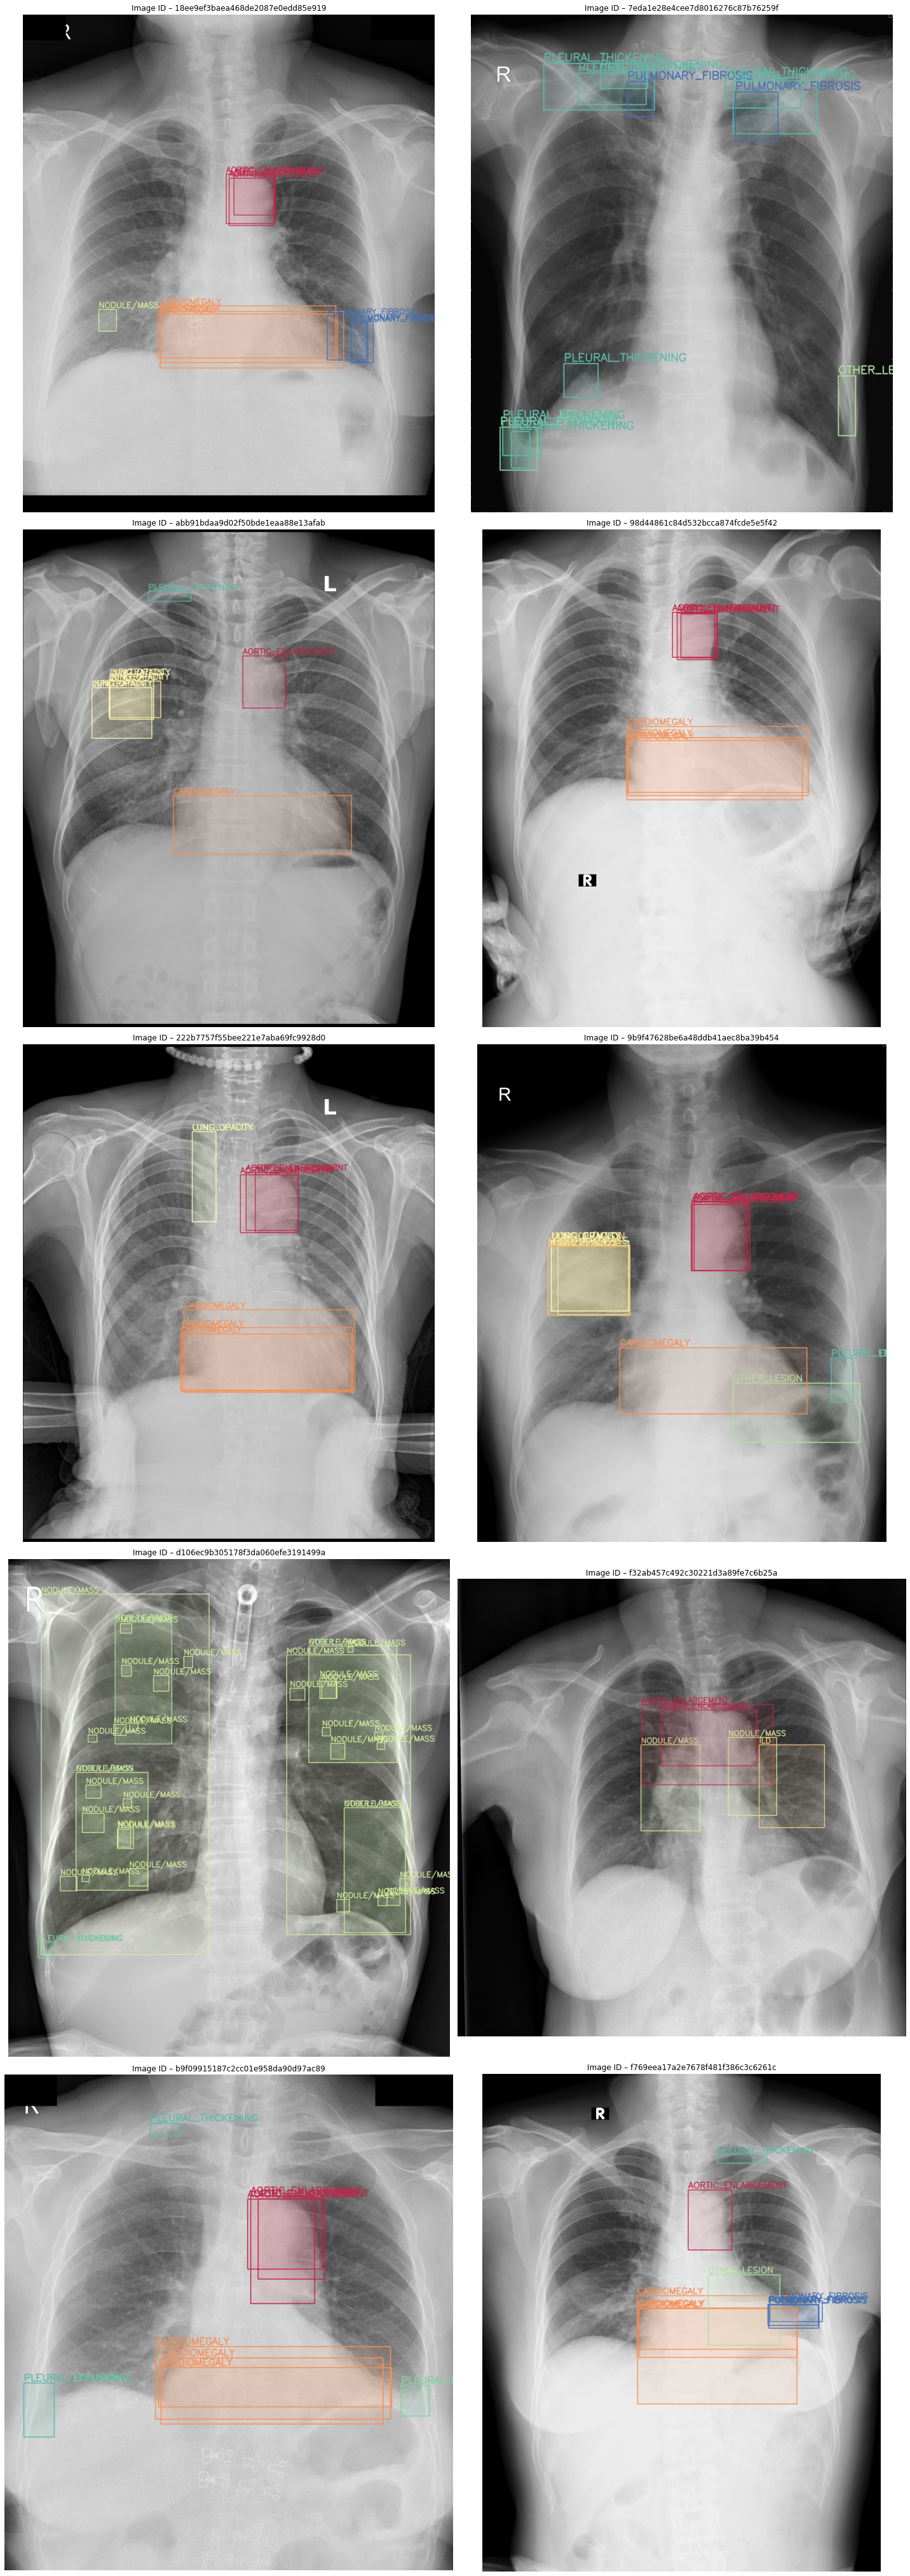

In [8]:
IMAGE_ID_LIST = train_df[train_df.class_id!=14].image_id[25:35].to_list()
train_data.plot_image_ids(image_id_list=IMAGE_ID_LIST, verbose=False)